## Poisson1D PINN

In [1]:
from __future__ import division, print_function

In [2]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

**Utils**

In [3]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [4]:
def plot_result(x,y,x_data,y_data,yh,xp=None):    
    plt.figure(figsize=(12,6))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc='upper right', frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.2, np.pi)
    plt.ylim(-1.5, 1.5)    
    plt.annotate("Training step: %i"%(i+1), 
             xy=(0, 1), 
             xycoords='axes fraction', 
             fontsize="xx-large", 
             color="k",
             ha='left', 
             va='top')
    plt.axis("off")

In [5]:
style = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master/styles/clean.mplstyle"

In [6]:
def style_plot(x, y, x_data, y_data, yh, xp=None):
    style = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master/styles/clean.mplstyle"
    with plt.style.context(style):        
        fig = plt.figure()
        ax = plt.subplot(111)
        plt.plot(x, y, label="Exact solution")
        if y_data is not None:            
            plt.scatter(x_data, y_data, label='Training data')
        if yh is not None:
            plt.plot(x, yh, label="Neural network prediction")
        if xp is not None:
            plt.scatter(xp, -0*torch.ones_like(xp), label='Physics loss training locations')
        plt.annotate("Training step: %i"%(i+1), 
             xy=(0, 1), 
             xycoords='axes fraction', 
             fontsize="small", 
             color="k",
             ha='left', 
             va='top')
        plt.legend(loc='best')

**Main Problem**

In [7]:
def f_rhs(x):
   return -4*torch.sin(2 * x)

def exact_u(x):
    return torch.sin(2 * x)

class FCN(nn.Module):  
  def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
    super().__init__()
    activation = nn.Tanh
    self.fcs = nn.Sequential(*[
        nn.Linear(N_INPUT, N_HIDDEN),
        activation()])
    self.fch = nn.Sequential(*[
                  nn.Sequential(*[
                      nn.Linear(N_HIDDEN, N_HIDDEN),
                      activation()]) for _ in range(N_LAYERS-1)])
    self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

  def forward(self, x):
    x = self.fcs(x)
    x = self.fch(x)
    x = self.fce(x)
    return x

### **Training data**

torch.Size([1000, 1]) torch.Size([1000, 1])
torch.Size([5, 1]) torch.Size([5, 1])


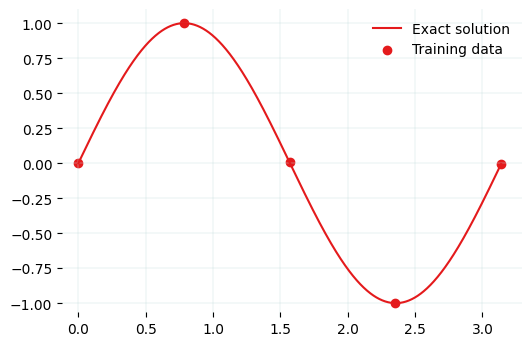

In [8]:
n_pts = 1000

x = np.array([np.pi/n_pts * i for i in range(n_pts)])
x = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y = exact_u(x).view(-1, 1)
print(x.shape, y.shape)

num_samples = 5
indices = np.linspace(0, len(x)-1, num_samples, dtype=int)
x_data = x[indices]
y_data = y[indices]
print(x_data.shape, y_data.shape)

with plt.style.context(style):        
        fig = plt.figure()
        ax = plt.subplot(111)
        plt.plot(x, y, label="Exact solution")        
        plt.scatter(x_data, y_data, label='Training data')        
        plt.legend()

### **Normal Neural Network**

In [9]:
torch.manual_seed(123)
model = FCN(1, 1, 10, 4)
model

FCN(
  (fcs): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (fch): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): Tanh()
    )
  )
  (fce): Linear(in_features=10, out_features=1, bias=True)
)

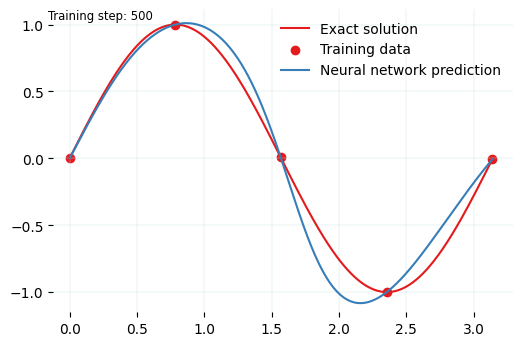

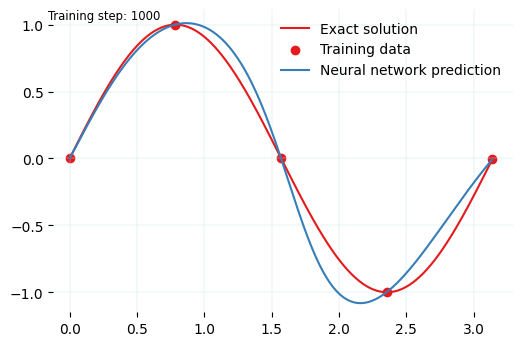

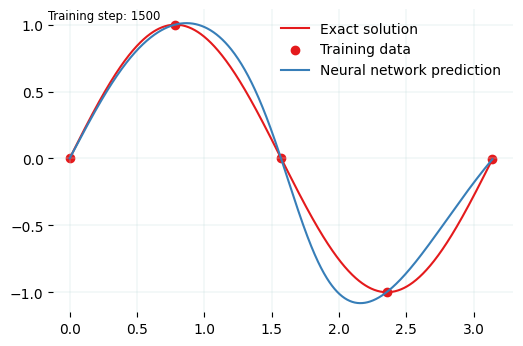

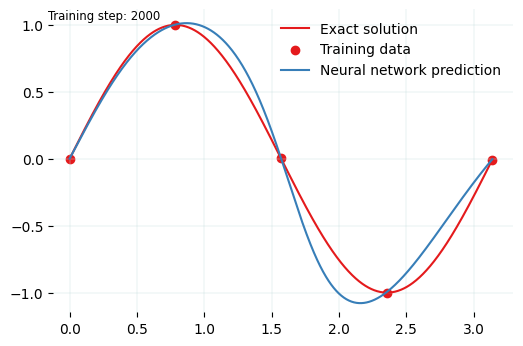

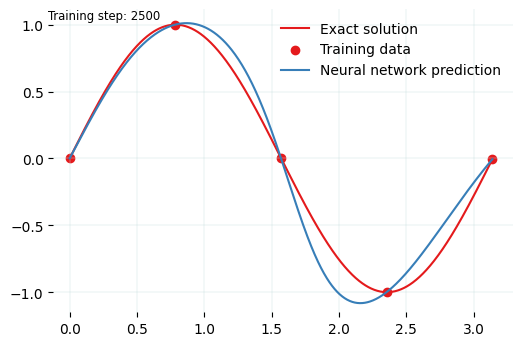

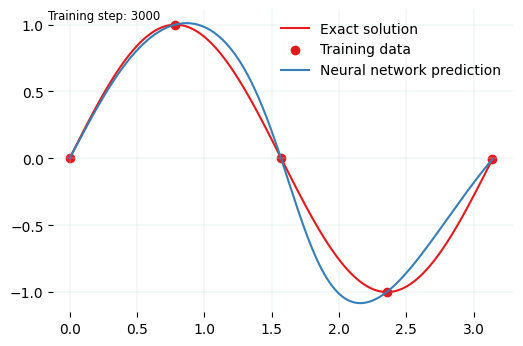

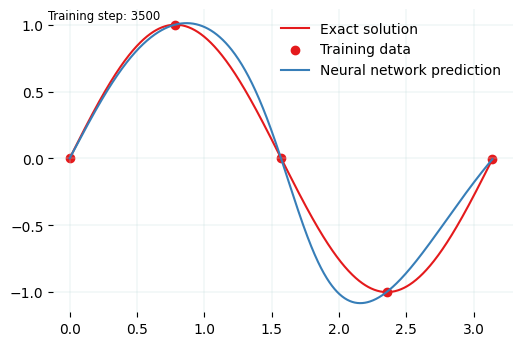

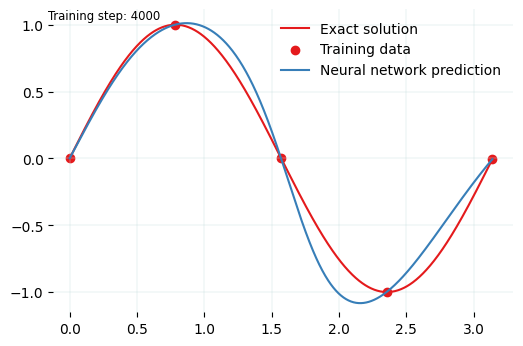

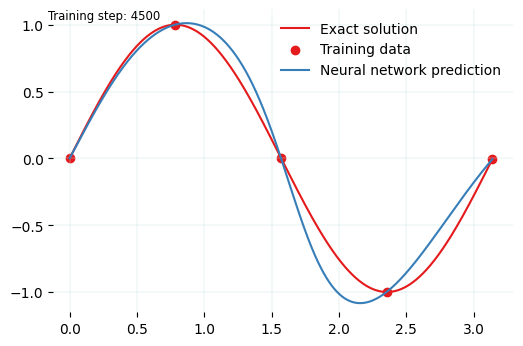

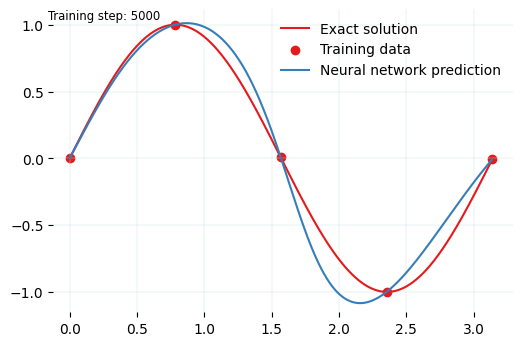

In [11]:
model = FCN(1, 1, 10, 4)
n_iterations = 5000
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
files = []
for i in range(n_iterations):
  optimizer.zero_grad()
  yh = model(x_data)
  loss = torch.mean((yh-y_data)**2)
  loss.backward()
  optimizer.step()

  if (i+1) % 10 == 0:
    yh = model(x).detach()
    #plot_result(x, y, x_data, y_data, yh)
    style_plot(x, y, x_data, y_data, yh)
    file = "plots/nn_%.8i.png"%(i+1)    
    plt.savefig(file, bbox_inches='tight', pad_inches=0.5, dpi=100, facecolor="white")
    files.append(file)

    if (i+1) % 500 == 0: plt.show()
    else: plt.close("all")
save_gif_PIL("nn.gif", files, fps=20, loop=0)

### **PINN**

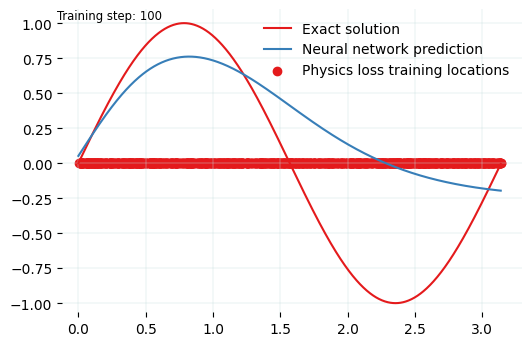

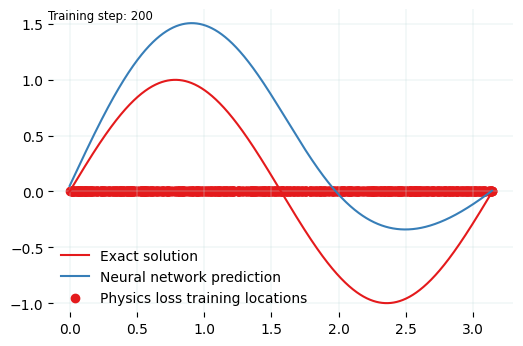

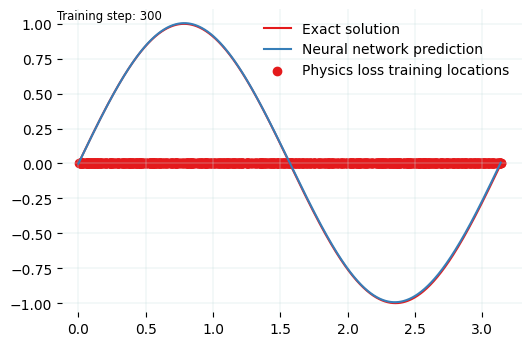

In [81]:
x_physics = torch.FloatTensor(n_pts,1).uniform_(0, np.pi).requires_grad_(True)
iterations = 300

torch.manual_seed(123)
model = FCN(1, 1, 10, 4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
files = []
for i in range(iterations):
  optimizer.zero_grad()

  # Data loss
  #yh = model(x_data)
  #loss1 = torch.mean((yh-y_data)**2)

  # Physic loss
  yhp = model(x_physics)
  du = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
  ddu = torch.autograd.grad(du, x_physics, torch.ones_like(du), create_graph=True)[0]
  error_PDE = torch.mean((ddu - f_rhs(x_physics))**2)
  bc = model(torch.tensor([np.pi]))**2 + model(torch.tensor([0.]))**2
  loss2 = error_PDE + bc

  # Backpropagation
  loss = loss2 #+ loss1 
  loss.backward()
  optimizer.step()

  if (i+1) % 1 == 0:

        yh = model(x).detach()
        xp = x_physics.detach()

        #plot_result(x,y,x_data,y_data,yh,xp)
        style_plot(x, y, x_data=None, y_data=None, yh=yh, xp=xp)

        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i+1) % 100 == 0: plt.show()
        else: plt.close("all")
save_gif_PIL("pinn.gif", files, fps=20, loop=0)